# Tutorial 6: Solver Settings

Though solving the model relies on the JuMP function `optimize`, there are a number of ways to change the way in which the model is optimized. This tutorial goes over solver parameters and how they affect the model solution. For more information on configuring the solver, see <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/solver_configuration/" target="_blank">here</a> in the GenX documentation.

## Table of Contents
* [The HiGHs Solver](#HiGHs)
* [Feasibility Tolerance](#Feasibility)
* [PreSolve](#PreSolve)
* [Crossover](#Crossover)

In [1]:
using YAML
using GenX
using JuMP
using HiGHS
using DataFrames
using Plots
using Plotly

WebIO._IJuliaInit()

In [2]:
case = joinpath("example_systems_tutorials/1_three_zones_tutorials") 

genx_settings = GenX.get_settings_path(case, "genx_settings.yml");
writeoutput_settings = GenX.get_settings_path(case, "output_settings.yml")
setup = GenX.configure_settings(genx_settings,writeoutput_settings) 
settings_path = GenX.get_settings_path(case)

Configuring Settings


"example_systems/1_three_zones/settings"

In [3]:
### Create TDR_Results
if "TDR_results" in cd(readdir,case)
    rm(joinpath(case,"TDR_results"), recursive=true) 
end

TDRpath = joinpath(case, setup["TimeDomainReductionFolder"])
system_path = joinpath(case, setup["SystemFolder"])

if setup["TimeDomainReduction"] == 1
    GenX.prevent_doubled_timedomainreduction(system_path)
    if !GenX.time_domain_reduced_files_exist(TDRpath)
        println("Clustering Time Series Data (Grouped)...")
        GenX.cluster_inputs(case, settings_path, setup)
    else
        println("Time Series Data Already Clustered.")
    end
end

inputs = GenX.load_inputs(setup, case)

Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Error: Geography Key 1 is invalid. Select `System' or `Zone'.
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv

[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Dict{Any, Any} with 73 entries:
  "Z"                         => 3
  "LOSS_LINES"                => [1, 2]
  "STOR_HYDRO_SHORT_DURATION" => Int64[]
  "RET_CAP_CHARGE"            => Set{Int64}()
  "pC_D_Curtail"              => [50.0, 45.0, 27.5, 10.0]
  "pTrans_Max_Possible"       => [5.9, 4.0]
  "pNet_Map"                  => [1.0 -1.0 0.0; 1.0 0.0 -1.0]
  "omega"                     => [4.01099, 4.01099, 4.01099, 4.01099, 4.01099, …
  "pMax_Line_Reinforcement"   => [2.95, 2.0]
  "RET_CAP_ENERGY"            => Int64[]
  "RESOURCES"                 => AbstractResource[…
  "COMMIT"                    => [1, 2, 3]
  "pMax_D_Curtail"            => [1.0, 0.04, 0.024, 0.003]
  "STOR_ALL"                  => [8, 9, 10]
  "THERM_ALL"                 => [1, 2, 3]
  "dfCO2CapZones"             => [1 0 0; 0 1 0; 0 0 1]
  "REP_PERIOD"                => 11
  "MinCapReq"                 => [5.0, 10.0, 6.0]
  "PWFU_Num_Segments"         => 0
  "STOR_LONG_DURATION"        => Int64[]
  "THERM_COMMIT_P

### The HiGHS Solver

In the example files, the solver <a href="https://highs.dev" target="_blank">HiGHS</a>. HiGHS is freely available for all to use. Other solvers, such as  <a href="https://www.gurobi.com" target="_blank">Gurobi</a>, are available for free for academics, and some <a href="https://genxproject.github.io/GenX.jl/dev/Getting_Started/commercial_solvers/" target="_blank">commercial solvers </a> such as CPLEX are also available. For the purpose of this tutorial, we will be focusing on HiGHS. 

To set the solver preferences, go into the settings folder of your case and select the YAML file of the solver you're using.



In [4]:
settings_folder = cd(readdir,joinpath(case,"settings")) # Print Settings folder

6-element Vector{String}:
 "clp_settings.yml"
 "cplex_settings.yml"
 "genx_settings.yml"
 "gurobi_settings.yml"
 "highs_settings.yml"
 "time_domain_reduction_settings.yml"

In [5]:
highs_settings = YAML.load(open(joinpath(case,"settings/highs_settings.yml")))

Dict{Any, Any} with 6 entries:
  "Method"        => "ipm"
  "Feasib_Tol"    => 1.0e-5
  "run_crossover" => "on"
  "TimeLimit"     => 1.0e23
  "Optimal_Tol"   => 1.0e-5
  "Pre_Solve"     => "choose"

The function <a href="https://genxproject.github.io/GenX/dev/solver_configuration/#Configuring-HiGHS" target="_blank">`configure_highs`</a> in `src/configure_solver` contains a list of default settings for the HiGHS solver



<img src="./files/highs_defaults.png" style="width: auto; height: 500px" align="left">



There are about 80, so we'll only focus on a few for now. In most cases, you can leave the other settings on default. 

The default settings are combined with the settings you specify in `highs_settings.yml` in `configure_highs`, which is called from `configure_solver` in `run_genx_case_simple` right before the model is generated.



### Feasibility Tolerance <a id="Feasibility"></a>

The parameters `Feasib_Tol` and `Optimal_Tol` represent the feasibility of the primal and dual functions respectively. Without going into too much detail, a  <a href="https://en.wikipedia.org/wiki/Duality_(optimization)" target="_blank">__dual function__</a> is an analagous formulation of the original ("primal") function whose objective value acts as a lower bound to the primal function. The objective value of the primal function is then the upper bound of the dual function. HiGHS will solve the dual and primal at each time step, then terminate when the solutions of the two are within a certain tolerance range. For more information on how this works specifically in HiGHS, see the  <a href="https://ergo-code.github.io/HiGHS/dev/terminology/" target="_blank">HiGHS documentaion</a>. 

If we decrease the tolerance parameters, the objective value becomes closer to the "true" optimal value. Note: The following cell will take a few minutes to run.



In [6]:
# Change tolerance, generate and solve model`
tols = [1e-7,1e-4,1e-2,1e-1]
OV = zeros(1,4)

for i in range(1,length(tols))
    println(" ")
    println("----------------------------------------------------")
    println("Iteration ",i)
    println("Tolerance = ",tols[i])
    println("----------------------------------------------------")
    highs_settings["Feasib_Tol"] = tols[i]
    highs_settings["Optimal_Tol"] = tols[i]
    YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)
    OPTIMIZER1 = GenX.configure_solver(settings_path,HiGHS.Optimizer)
    EP = GenX.generate_model(setup,inputs,OPTIMIZER1)
    GenX.solve_model(EP,setup)
    OV[i] = objective_value(EP)
end



 
----------------------------------------------------
Iteration 1
Tolerance = 1.0e-7
----------------------------------------------------
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118181 rows, 81226 cols, 467256 nonzeros
110762 rows, 73807 cols, 468798 nonzeros
Presolve : Reductions: rows 110762(-42636); columns 73807(-46332); elements 468798(-46715)
Solving the presolved LP
IPX model has 110762 rows, 73807 columns and 468798 nonzeros
Input
    Number of variables:                                73807
    

 
----------------------------------------------------
Iteration 2
Tolerance = 0.0001
----------------------------------------------------
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118181 rows, 81226 cols, 467256 nonzeros
110762 rows, 73807 cols, 468798 nonzeros
Presolve : Reductions: rows 110762(-42636); columns 73807(-46332); elements 468798(-46715)
Solving the presolved LP
IPX model has 110762 rows, 73807 columns and 468798 nonzeros
Input
    Number of variables:                                73807
    

Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
118181 rows, 77691 cols, 456651 nonzeros
110762 rows, 70272 cols, 458193 nonzeros
Presolve : Reductions: rows 110762(-42636); columns 70272(-49867); elements 458193(-57320)
Solving the presolved LP
IPX model has 110762 rows, 70272 columns and 458193 nonzeros
Input
    Number of variables:                                70272
    Number of free variables:                           3696
    Number of constraints:                              110762
    Number of equality constraints:                     16605

Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115640 rows, 69450 cols, 429387 nonzeros
108221 rows, 62031 cols, 430929 nonzeros
Presolve : Reductions: rows 108221(-45177); columns 62031(-58108); elements 430929(-84584)
Solving the presolved LP
IPX model has 108221 rows, 62031 columns and 430929 nonzeros
Input
    Number of variables:                                62031
    Number of free variables:                           3696
    Number of constraints:                              108221
    Number of equality constraints: 

Using the smallest tolerance as our base, we can see the error as the tolerance increases:



In [7]:
DataFrame([tols[2:end] abs.(OV[2:end] .- OV[1])],["Tolerance", "Error"])

Row,Tolerance,Error
,Float64,Float64
1,0.0001,0.0
2,0.01,1.45519e-11
3,0.1,2.72848e-11


In [8]:
using Plots
using Plotly

┌ Warning: backend `PlotlyJS` is not installed.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:43


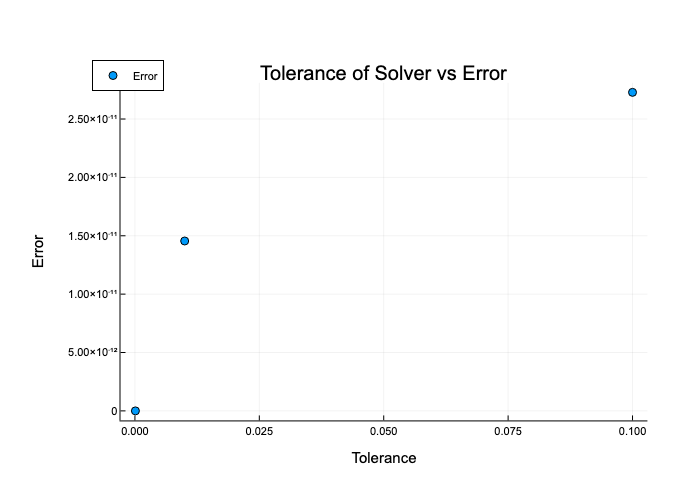

In [9]:
# Plot the error as a function of the tolerance
plotlyjs()
Plots.scatter(tols[2:end], abs.(OV[2:end] .- OV[1]),legend=:topleft,
                ylabel="Error", xlabel="Tolerance",size=(920,400),label=:"Error",title="Tolerance of Solver vs Error")
ygrid!(:on, :dashdot, 0.1)

### PreSolve <a id="PreSolve"></a>

In optimization, presolve is a stage at the beginning of the solver in which the problem is simplified to remove redunant constraints and otherwise streamline the problem before the optimization itself begins. The default for presolve in GenX is "choose", allowing the solver to use presolve only if it will reduce computation time. 

Let's try setting presolve to off and on, then compare computation times.



In [ ]:
# First, set tolerances back to original
highs_settings["Feasib_Tol"] = 1e-5
highs_settings["Optimal_Tol"] = 1e-5
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)    

In [ ]:
highs_settings["Pre_Solve"] = "off"
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)
OPTIMIZER2 = GenX.configure_solver(settings_path, HiGHS.Optimizer);
EP2 = GenX.generate_model(setup, inputs, OPTIMIZER2)

In [ ]:
solution2 = @elapsed GenX.solve_model(EP2,setup)

In [ ]:
highs_settings["Pre_Solve"] = "on"
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)
OPTIMIZER3 = GenX.configure_solver(settings_path,HiGHS.Optimizer);
EP3 = GenX.generate_model(setup,inputs,OPTIMIZER3)

In [ ]:
solution3 = @elapsed GenX.solve_model(EP3,setup)

As we can see, the runtime with PreSolve is shorter, and would be even shorter for a larger system. However, PreSolve can sometimes introduce numerical inaccuracies. If you find the model is struggling to converge, try turning PreSolve off.



In [ ]:
# Write PreSolve back to choose
highs_settings["Pre_Solve"] = "choose"
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)

### Crossover <a id="Crossover"></a>

Crossover is a method in which, at each step of the optimization algorithm, the solution is pushed to the boundary of the solution space. This allows for a potentially more accurate solution, but can be computationally intensive. The default for `1_three_zones` is "on". Let's try turning crossover on and off and see what solutions we get:

In [ ]:
highs_settings["run_crossover"] = "off"
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)
OPTIMIZER4 = GenX.configure_solver(settings_path,HiGHS.Optimizer);
EP4 = GenX.generate_model(setup,inputs,OPTIMIZER4)

In [ ]:
solution4 = @elapsed GenX.solve_model(EP4,setup)

In [ ]:
highs_settings["run_crossover"] = "on"
YAML.write_file(joinpath(case,"settings/highs_settings.yml"), highs_settings)
OPTIMIZER5 =  GenX.configure_solver(settings_path,HiGHS.Optimizer);
EP5 = GenX.generate_model(setup,inputs,OPTIMIZER5)

In [ ]:
solution5 = @elapsed GenX.solve_model(EP5,setup)